<a href="https://colab.research.google.com/github/jeyasri-s2/SJSU297-AdvancedDL/blob/master/Assignment2_GradientTapeCustomClass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Packages

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import backend as K

In [ ]:
class Linear(keras.layers.Layer):
    def __init__(self, units=32, input_dim=32):
        super(Linear, self).__init__()
        self.w = self.add_weight(
            shape=(input_dim, units), initializer="random_normal", trainable=True
        )
        self.b = self.add_weight(shape=(units,), initializer="zeros", trainable=True)

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b


x = tf.ones((2, 2))
linear_layer = Linear(4, 2)
y = linear_layer(x)
print(y)

tf.Tensor(
[[-0.09822845  0.00902112  0.05487917  0.05804853]
 [-0.09822845  0.00902112  0.05487917  0.05804853]], shape=(2, 4), dtype=float32)


In [ ]:
import numpy as np
import pandas as pd

from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, recall_score, f1_score, accuracy_score, precision_score
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.decomposition import PCA, IncrementalPCA, LatentDirichletAllocation
from sklearn.manifold import TSNE

In [ ]:
!pip install wget

In [ ]:
import wget

filename = wget.download('http://www3.dsi.uminho.pt/pcortez/wine/winequality.zip')
filename

'winequality (1).zip'

In [ ]:
!unzip winequality.zip

Archive:  winequality.zip
replace winequality/winequality-names.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
!ls winequality

winequality-names.txt	   winequality-red.csv
winequality-names.txt.bak  winequality-white.csv


In [ ]:
import pandas as pd
red_wine_data = pd.read_csv("winequality/winequality-red.csv",delimiter=';')
red_wine_data.head(2)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.0,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5


In [ ]:
white_wine_data = pd.read_csv("winequality/winequality-white.csv",delimiter=';')
white_wine_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [ ]:
white_wine_data['name'] = 'white'
red_wine_data['name'] = 'red'
white_wine_data['label'] = 1
red_wine_data['label'] = 0

In [ ]:
wine_data = pd.concat([red_wine_data,white_wine_data],axis=0)
wine_data.shape

(6497, 14)

In [ ]:
wine_data['quality'] = wine_data['quality'].apply(lambda x: float(x))

In [ ]:
wine_data.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                 float64
name                     object
label                     int64
dtype: object

# Train test Split

In [ ]:
wine_data.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                 float64
name                     object
label                     int64
dtype: object

In [ ]:
columns = [ 'alcohol','quality','sulphates','pH','density','total sulfur dioxide','free sulfur dioxide','chlorides','residual sugar'	,'citric acid','volatile acidity','fixed acidity']
X = wine_data[columns]
Y = wine_data[['label']]



In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

print(X_train.shape)
print(X_test.shape)

(4547, 12)
(1950, 12)


# using gradient tape for gradient computation

In [ ]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
columns = [ 'alcohol','quality','sulphates','pH','density','total sulfur dioxide','free sulfur dioxide','chlorides','residual sugar'	,'citric acid','volatile acidity','fixed acidity']


feature_names = columns
label_name = 'label'

print("Features: {}".format(feature_names))
print("Label: {}".format(label_name))

Features: ['alcohol', 'quality', 'sulphates', 'pH', 'density', 'total sulfur dioxide', 'free sulfur dioxide', 'chlorides', 'residual sugar', 'citric acid', 'volatile acidity', 'fixed acidity']
Label: label


In [ ]:
target = wine_data.pop('label')
name = wine_data.pop('name')
batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices((wine_data.to_dict('list'), target.values)).batch(batch_size)


In [ ]:
features, labels = next(iter(train_dataset))

print(features)

{'fixed acidity': <tf.Tensor: shape=(32,), dtype=float32, numpy=
array([ 7.4,  7.8,  7.8, 11.2,  7.4,  7.4,  7.9,  7.3,  7.8,  7.5,  6.7,
        7.5,  5.6,  7.8,  8.9,  8.9,  8.5,  8.1,  7.4,  7.9,  8.9,  7.6,
        7.9,  8.5,  6.9,  6.3,  7.6,  7.9,  7.1,  7.8,  6.7,  6.9],
      dtype=float32)>, 'volatile acidity': <tf.Tensor: shape=(32,), dtype=float32, numpy=
array([0.7  , 0.88 , 0.76 , 0.28 , 0.7  , 0.66 , 0.6  , 0.65 , 0.58 ,
       0.5  , 0.58 , 0.5  , 0.615, 0.61 , 0.62 , 0.62 , 0.28 , 0.56 ,
       0.59 , 0.32 , 0.22 , 0.39 , 0.43 , 0.49 , 0.4  , 0.39 , 0.41 ,
       0.43 , 0.71 , 0.645, 0.675, 0.685], dtype=float32)>, 'citric acid': <tf.Tensor: shape=(32,), dtype=float32, numpy=
array([0.  , 0.  , 0.04, 0.56, 0.  , 0.  , 0.06, 0.  , 0.02, 0.36, 0.08,
       0.36, 0.  , 0.29, 0.18, 0.19, 0.56, 0.28, 0.08, 0.51, 0.48, 0.31,
       0.21, 0.11, 0.14, 0.16, 0.24, 0.21, 0.  , 0.  , 0.07, 0.  ],
      dtype=float32)>, 'residual sugar': <tf.Tensor: shape=(32,), dtype=float32, nump

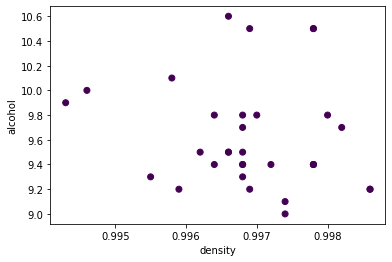

In [ ]:
plt.scatter(features['density'],
            features['alcohol'],
            c=labels,
            cmap='viridis')

plt.xlabel("density")
plt.ylabel("alcohol")
plt.show()

In [ ]:
def pack_features_vector(features, labels):
  """Pack the features into a single array."""
  features = tf.stack(list(features.values()), axis=1)
  return features, labels

In [ ]:
train_dataset = train_dataset.map(pack_features_vector)


In [ ]:
features, labels = next(iter(train_dataset))

print(features[:5])

tf.Tensor(
[[7.400e+00 7.000e-01 0.000e+00 1.900e+00 7.600e-02 1.100e+01 3.400e+01
  9.978e-01 3.510e+00 5.600e-01 9.400e+00 5.000e+00]
 [7.800e+00 8.800e-01 0.000e+00 2.600e+00 9.800e-02 2.500e+01 6.700e+01
  9.968e-01 3.200e+00 6.800e-01 9.800e+00 5.000e+00]
 [7.800e+00 7.600e-01 4.000e-02 2.300e+00 9.200e-02 1.500e+01 5.400e+01
  9.970e-01 3.260e+00 6.500e-01 9.800e+00 5.000e+00]
 [1.120e+01 2.800e-01 5.600e-01 1.900e+00 7.500e-02 1.700e+01 6.000e+01
  9.980e-01 3.160e+00 5.800e-01 9.800e+00 6.000e+00]
 [7.400e+00 7.000e-01 0.000e+00 1.900e+00 7.600e-02 1.100e+01 3.400e+01
  9.978e-01 3.510e+00 5.600e-01 9.400e+00 5.000e+00]], shape=(5, 12), dtype=float32)


# Define model

In [ ]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(12,)),  # input shape required
  tf.keras.layers.Dense(10, activation=tf.nn.relu),
  tf.keras.layers.Dense(3)
])

In [ ]:
features.shape

TensorShape([32, 12])

In [ ]:
predictions = model(features)
predictions[:5]

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[-2.605095 , -0.8592084,  1.1755774],
       [-8.014863 , -2.329384 ,  3.8004751],
       [-6.3847384, -1.8556159,  3.0275052],
       [-7.5656333, -2.198823 ,  3.58746  ],
       [-2.605095 , -0.8592084,  1.1755774]], dtype=float32)>

In [ ]:
tf.nn.softmax(predictions[:5])

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[1.9772032e-02, 1.1331313e-01, 8.6691487e-01],
       [7.3742231e-06, 2.1721432e-03, 9.9782050e-01],
       [8.1096579e-05, 7.5158067e-03, 9.9240315e-01],
       [1.4286831e-05, 3.0599339e-03, 9.9692577e-01],
       [1.9772032e-02, 1.1331313e-01, 8.6691487e-01]], dtype=float32)>

In [ ]:
print("Prediction: {}".format(tf.argmax(predictions, axis=1)))
print("    Labels: {}".format(labels))

Prediction: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
    Labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)


In [ ]:
def loss(model, x, y, training):
  # training=training is needed only if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  y_ = model(x, training=training)

  return loss_object(y_true=y, y_pred=y_)


l = loss(model, features, labels, training=False)
print("Loss test: {}".format(l))

Loss test: 10.348146438598633


In [ ]:
def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets, training=True)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

loss_value, grads = grad(model, features, labels)

print("Step: {}, Initial Loss: {}".format(optimizer.iterations.numpy(),
                                          loss_value.numpy()))



optimizer.apply_gradients(zip(grads, model.trainable_variables))

print("Step: {},         Loss: {}".format(optimizer.iterations.numpy(),
                                          loss(model, features, labels, training=True).numpy()))

Step: 0, Initial Loss: 10.348146438598633
Step: 1,         Loss: 2.063204288482666


In [ ]:
## Note: Rerunning this cell uses the same model variables

# Keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 5

for epoch in range(num_epochs):
  epoch_loss_avg = tf.keras.metrics.Mean()
  epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

  # Training loop - using batches of 32
  for x, y in train_dataset:
    # Optimize the model
    loss_value, grads = grad(model, x, y)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Track progress
    epoch_loss_avg.update_state(loss_value)  # Add current batch loss
    # Compare predicted label to actual label
    # training=True is needed only if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    epoch_accuracy.update_state(y, model(x, training=True))

  # End epoch
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())

  if epoch % 50 == 0:
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))

Epoch 000: Loss: 0.184, Accuracy: 98.245%


# Custom layer with gradient Tape without Keras

# Custom Linear classifier

In [ ]:
input_dim = 2
output_dim = 1
learning_rate = 0.01

# This is our weight matrix
w = tf.Variable(tf.random.uniform(shape=(input_dim, output_dim)))
# This is our bias vector
b = tf.Variable(tf.zeros(shape=(output_dim,)))

def compute_predictions(features):
  return tf.matmul(features, w) + b

def compute_loss(labels, predictions):
  return tf.reduce_mean(tf.square(labels - predictions))

def train_on_batch(x, y):
  with tf.GradientTape() as tape:
    predictions = compute_predictions(x)
    loss = compute_loss(y, predictions)
    # Note that `tape.gradient` works with a list as well (w, b).
    dloss_dw, dloss_db = tape.gradient(loss, [w, b])
  w.assign_sub(learning_rate * dloss_dw)
  b.assign_sub(learning_rate * dloss_db)
  return loss

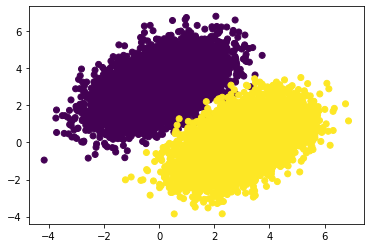

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

# Prepare a dataset.
num_samples = 10000
negative_samples = np.random.multivariate_normal(
    mean=[0, 3], cov=[[1, 0.5],[0.5, 1]], size=num_samples)
positive_samples = np.random.multivariate_normal(
    mean=[3, 0], cov=[[1, 0.5],[0.5, 1]], size=num_samples)
features = np.vstack((negative_samples, positive_samples)).astype(np.float32)
labels = np.vstack((np.zeros((num_samples, 1), dtype='float32'),
                    np.ones((num_samples, 1), dtype='float32')))

plt.scatter(features[:, 0], features[:, 1], c=labels[:, 0])

In [ ]:
# Shuffle the data.
indices = np.random.permutation(len(features))
features = features[indices]
labels = labels[indices]

# Create a tf.data.Dataset object for easy batched iteration
dataset = tf.data.Dataset.from_tensor_slices((features, labels))
dataset = dataset.shuffle(buffer_size=1024).batch(256)

for epoch in range(10):
  for step, (x, y) in enumerate(dataset):
    loss = train_on_batch(x, y)
  print('Epoch %d: last batch loss = %.4f' % (epoch, float(loss)))

Epoch 0: last batch loss = 0.0588
Epoch 1: last batch loss = 0.0503
Epoch 2: last batch loss = 0.0349
Epoch 3: last batch loss = 0.0236
Epoch 4: last batch loss = 0.0290
Epoch 5: last batch loss = 0.0290
Epoch 6: last batch loss = 0.0305
Epoch 7: last batch loss = 0.0248
Epoch 8: last batch loss = 0.0414
Epoch 9: last batch loss = 0.0189


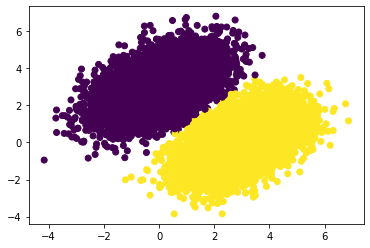

In [ ]:
predictions = compute_predictions(features)
plt.scatter(features[:, 0], features[:, 1], c=predictions[:, 0] > 0.5)